<a href="https://colab.research.google.com/github/vladi29/ANA-Classifier/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Universidad Simon Bolivar - 26 de Enero de 2022
# Trabajo final de grado: Clasificador de patrones ANA
# Vladimir Alfaro - 1510023

# Creacion, entrenamiento y prueba de la red

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os
import time

Image name:  ['691_1.jpg']
Label:  Negative
Image name:  ['145_5.jpg']
Label:  FineSpeckled_CytoplasmicPolarGolgiLike
Image name:  ['388_2.bmp']
Label:  NuclearMembranous_CytoplasmicReticularAMA
Image name:  ['139_3.png']
Label:  FineSpeckled_CytoplasmicFibrillar
Image name:  ['357_3.jpg']
Label:  NuclearHomogeneous_NucleolarHomogeneous
Image name:  ['252_2.png']
Label:  NuclearHomogeneous_CoarseSpeckled


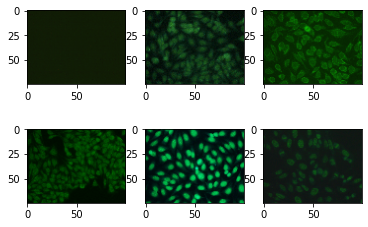

In [2]:
#----------Paths----------

labels_path = 'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/labels.csv'
names_path = 'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/names.csv'
images_path = 'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/images.npz'

labels_raw = pd.read_csv(labels_path, header = None)
labels_raw = labels_raw.values.tolist()
labels = []
for label in labels_raw:
  labels.append(label[0])

names = pd.read_csv(names_path, header = None)
names = names.values.tolist()

images = np.load(images_path)
images = images['arr_0']

images_list = []
labels_list = []
names_list = []

for i in range(0, 6):
    A = random.randint(0, 2079)
    images_list.append(images[A])
    labels_list.append(labels[A])
    names_list.append(names[A])

for i in range(0,6):
    plt.subplot(2,3, i+1)
    imagen = images_list[i]
    print("Image name: ", names_list[i])
    print("Label: ", labels_list[i])
    plt.imshow(imagen)
plt.show()

In [3]:
#Preparando la data para cambiar las clases por 1 para positivos y 0 para negativos

binary_labels = []
for label in labels:
  if label == 'Negative':
    binary_labels.append(0)
  else: 
    binary_labels.append(1)

#Division de la data para entrenar, validar y probar la red
x_train, x_val_test, y_train, y_val_test = train_test_split(images, binary_labels, test_size = 0.3)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size = 0.5)

print("Muestras en el set de entrenamiento: ", len(x_train))
print("Muestras en el set de validacion: ", len(x_val))
print("Muestras en el set de pruebas: ", len(x_test))

Muestras en el set de entrenamiento:  1455
Muestras en el set de validacion:  312
Muestras en el set de pruebas:  312


tensor(1)


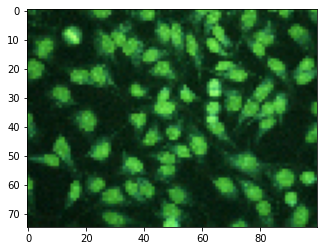

tensor(1)


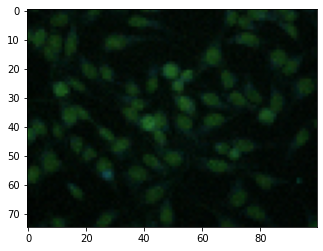

tensor(1)


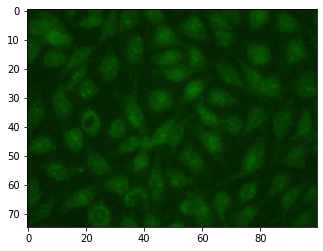

In [4]:
#Clase Dataset Personaliazdo

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.labels = labels
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        return image, label

#Creando Dataloader para los conjuntos de entrenamiento y prueba
       
train_data = CustomImageDataset(x_train, y_train)
train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)

val_data = CustomImageDataset(x_val, y_val)
val_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)

test_data = CustomImageDataset(x_test, y_test)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)

images, labels = next(iter(train_dataloader))
plt.imshow(images[0])
print(labels[0])
plt.show()

images, labels = next(iter(val_dataloader))
plt.imshow(images[0])
print(labels[0])
plt.show()

images, labels = next(iter(test_dataloader))
plt.imshow(images[0])
print(labels[0])
plt.show()

In [18]:
# Creacion de la InmunoNet

class InmunoNet(nn.Module):
  def __init__(self, numChannels, numClasses):
    super(InmunoNet, self).__init__()

    # Se inicializa la primera capa convolucional (CONV => RELU => POOL layers)
    self.conv1 = nn.Conv2d(in_channels = numChannels, out_channels = 10, kernel_size = (5, 5)) # 3 canales de entrada y 10 de salida
    self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # Se inicializa la segunda capa convolucional (CONV => RELU => POOL layers)
    self.conv2 = nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = (5, 5)) # 10 canales de entrada y 20 de salida
    self.maxpool2 = nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2))

    # Se inicializa la tercera capa convolucional (CONV => RELU => POOL layers)
    self.conv3 = nn.Conv2d(in_channels = 20, out_channels = 40, kernel_size = (4, 4)) # 20 canales de entrada y 40 de salida
    self.maxpool3 = nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2))

    # initialize first set of FC => RELU layers
    self.fc1 = nn.Linear(in_features = 2160, out_features = 2160)

    # initialize second set of FC => RELU layers
    self.fc2 = nn.Linear(in_features = 2160, out_features = 1000)

    # initialize third set of FC => RELU layers
    self.fc3 = nn.Linear(in_features = 1000, out_features = 500)

    # initialize fouth set of FC => RELU layers
    self.fc4 = nn.Linear(in_features = 500, out_features = 500)

    # Final set of FC
    self.fcout = nn.Linear(in_features = 500, out_features = numClasses)
    self.relu = nn.ReLU()
    self.Softmax = nn.Softmax(dim=1)
    self.sigmoid = nn.Sigmoid()
    self.dropout = nn.Dropout(0.5) # Dropout con 30% de porbabilidades de desactivar cada neuronar

  def forward(self, x):

    # Modificando el orden de los tensores (batch, canales, alto, ancho)
    x = x.permute(0, 3, 1, 2)

    # pass the input through our first set of CONV => RELU => POOL layers
    x = self.conv1(x)
    x = self.relu(x)
    x = self.maxpool1(x)

    # pass the output from the previous layer through the second set of CONV => RELU => POOL layers
    x = self.conv2(x)
    x = self.relu(x)
    x = self.maxpool2(x)

    # pass the output from the previous layer through the second set of CONV => RELU => POOL layers
    x = self.conv3(x)
    x = self.relu(x)
    x = self.maxpool3(x)
    
    # flatten the output from the previous layer and pass it through our first set of FC => RELU layers
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.dropout(x)
    x = self.relu(x)
    
    # pass the output from the previous layer through our second set of FC => RELU layers
    x = self.fc2(x)
    x = self.dropout(x)
    x = self.relu(x)

    # pass the output from the previous layer through our third set of FC => RELU layers
    x = self.fc3(x)
    x = self.dropout(x)
    x = self.relu(x)

    # pass the output from the previous layer through our third set of FC => RELU layers
    x = self.fc4(x)
    x = self.dropout(x)
    x = self.relu(x)

    # pass the output to our softmax classifier to get our output predictions
    x = self.fcout(x)
    output = self.sigmoid(x)
    #output = self.Softmax(x)
    
    # return the output predictions
    return output

In [28]:
# Funcion para el entrenamiento y validacion de la red

def train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs, device):
  # Inicializamos dos arreglos para guardar el costo por epoca para el entrenamiento y la validacion
  training_cost = []
  validation_cost = []

  for epoch in range(epochs):
    # Se inicializan la perdida del entrenamientos y de la validacion en 0
    training_batch_loss = []
    validation_batch_loss = []
    
    # Empieza el entrenamiento de la red
    model.train()
    Y_total = torch.ones((1,1)).to(device, torch.float32)      # Variable auxiliar para guardar todas las salidas
    Y_hat_total = torch.ones((1,1)).to(device, torch.float32)  # Variable auxiliar para guardar todas las salidas que predice el modelo
    for batch in iter(train_loader):
      X, Y = batch
      X = X.to(device, torch.float32)
      Y = Y.reshape((len(Y), 1))
      Y = Y.to(device, torch.float32)
      Y_hat = model(X)
      loss = loss_fn(Y_hat, Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      training_batch_loss.append(loss.data.item())
      Y_total = torch.cat((Y_total, Y), dim = 0)              # Concatenamos las salidas de cada lote
      Y_hat_total = torch.cat((Y_hat_total, Y_hat), dim = 0)  # Concatenamos las salidas que predice el modelo de cada lote
    training_cost_epoch = np.mean(training_batch_loss)
    training_cost.append(training_cost_epoch)
    Y_total = Y_total[1:]           # Retiramos el primer valor del tensor ya que es un 1
    Y_hat_total = Y_hat_total[1:]   # Retiramos el primer valor del tensor ya que es un 1
    Y_hat_total[Y_hat_total > 0.8] = 1
    Y_hat_total[Y_hat_total < 1] = 0
    if (device == "cuda"):
      training_epoch_acc = accuracy_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
      training_epoch_pre = precision_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
      training_epoch_recall = recall_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
      training_epoch_F1 = f1_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy()) 
    else:
      training_epoch_acc = accuracy_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
      training_epoch_pre = precision_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
      training_epoch_recall = recall_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
      training_epoch_F1 = f1_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
    print("Epoca: ", (epoch + 1), "/", epochs)
    print("Costo de entrenamiento ", round(training_cost_epoch, 5))

    # Empieza la validacion de la red
    model.eval()
    Y_total = torch.ones((1,1)).to(device, torch.float32)      # Variable auxiliar para guardar todas las salidas
    Y_hat_total = torch.ones((1,1)).to(device, torch.float32)  # Variable auxiliar para guardar todas las salidas que predice el modelo
    for batch in iter(val_loader):
      X, Y = batch
      X = X.to(device, torch.float32)
      Y = Y.reshape((len(Y), 1))
      Y = Y.to(device, torch.float32)
      Y_hat = model(X)
      loss = loss_fn(Y_hat, Y)
      validation_batch_loss.append(loss.data.item())
      Y_total = torch.cat((Y_total, Y), dim = 0)              # Concatenamos las salidas de cada lote
      Y_hat_total = torch.cat((Y_hat_total, Y_hat), dim = 0)  # Concatenamos las salidas que predice el modelo de cada lote
    validation_cost_epoch = np.mean(validation_batch_loss)
    validation_cost.append(validation_cost_epoch)
    Y_total = Y_total[1:]           # Retiramos el primer valor del tensor ya que es un 1
    Y_hat_total = Y_hat_total[1:]   # Retiramos el primer valor del tensor ya que es un 1
    Y_hat_total[Y_hat_total > 0.8] = 1
    Y_hat_total[Y_hat_total < 1] = 0
    if (device == "cuda"):
      validation_epoch_acc = accuracy_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
      validation_epoch_pre = precision_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
      validation_epoch_recall = recall_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
      validation_epoch_F1 = f1_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy()) 
    else:
      validation_epoch_acc = accuracy_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
      validation_epoch_pre = precision_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
      validation_epoch_recall = recall_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
      validation_epoch_F1 = f1_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
    print("Costo de validacion ", round(validation_cost_epoch, 5))
    print("Metricas del entrenmaiento:\n", "Exactitud: ", round(training_epoch_acc, 2), " Precision: ",
          round(training_epoch_pre, 2), " Recall: ", round(training_epoch_recall, 2), " F1: ", round(training_epoch_F1, 2))
    print("Metricas de la validacion:\n", "Exactitud: ", round(validation_epoch_acc, 2), " Precision: ",
          round(validation_epoch_pre, 2), " Recall: ", round(validation_epoch_recall, 2), " F1: ", round(validation_epoch_F1, 2), "\n")
  return training_cost, validation_cost   

  # Accuracy = TP + TN / (TP + TN + FP + FN)
  # Precision = TP / (TP + FP)
  # Recall = TP / (TP + FN) 
  # F1 = 2 * (Precision * Recall) / (Precision + Recall)

In [29]:
def test_model(model, test_loader, device):
  model.eval()
  Y_total = torch.ones((1,1)).to(device, torch.float32)      # Variable auxiliar para guardar todas las salidas
  Y_hat_total = torch.ones((1,1)).to(device, torch.float32)  # Variable auxiliar para guardar todas las salidas que predice el modelo
  for batch in iter(test_loader):
    X, Y = batch
    X = X.to(device, torch.float32)
    Y = Y.reshape((len(Y), 1))
    Y = Y.to(device, torch.float32)
    Y_hat = model(X)
    Y_total = torch.cat((Y_total, Y), dim = 0)               # Concatenamos las salidas de cada lote
    Y_hat_total = torch.cat((Y_hat_total, Y_hat), dim = 0)   # Concatenamos las salidas que predice el modelo de cada lote
  Y_total = Y_total[1:]           # Retiramos el primer valor del tensor ya que es un 1
  Y_hat_total = Y_hat_total[1:]   # Retiramos el primer valor del tensor ya que es un 1
  Y_hat_total[Y_hat_total > 0.8] = 1
  Y_hat_total[Y_hat_total < 1] = 0
  if (device == "cuda"):
    test_acc = accuracy_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
    test_pre = precision_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
    test_recall = recall_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
    test_F1 = f1_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy()) 
    test_confusion_matrix = confusion_matrix(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy()) 
  else:
    test_acc = accuracy_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
    test_pre = precision_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
    test_recall = recall_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
    test_F1 = f1_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
    test_confusion_matrix = confusion_matrix(Y_total.detach().numpy(), Y_hat_total.detach().numpy())

  return test_acc, test_pre, test_recall, test_F1, test_confusion_matrix


Epoca:  1 / 50
Costo de entrenamiento  0.58621
Costo de validacion  0.49145
Metricas del entrenmaiento:
 Exactitud:  0.4  Precision:  0.81  Recall:  0.21  F1:  0.33
Metricas de la validacion:
 Exactitud:  0.86  Precision:  0.91  Recall:  0.89  F1:  0.9 

Epoca:  2 / 50
Costo de entrenamiento  0.3988
Costo de validacion  0.35044
Metricas del entrenmaiento:
 Exactitud:  0.8  Precision:  0.95  Recall:  0.76  F1:  0.84
Metricas de la validacion:
 Exactitud:  0.78  Precision:  0.99  Recall:  0.71  F1:  0.83 

Epoca:  3 / 50
Costo de entrenamiento  0.34871
Costo de validacion  0.31838
Metricas del entrenmaiento:
 Exactitud:  0.8  Precision:  0.98  Recall:  0.74  F1:  0.85
Metricas de la validacion:
 Exactitud:  0.83  Precision:  0.98  Recall:  0.78  F1:  0.87 

Epoca:  4 / 50
Costo de entrenamiento  0.32433
Costo de validacion  0.30795
Metricas del entrenmaiento:
 Exactitud:  0.82  Precision:  0.98  Recall:  0.77  F1:  0.86
Metricas de la validacion:
 Exactitud:  0.87  Precision:  0.97  Reca

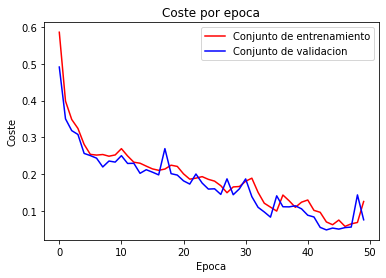

In [30]:
# Creacion del modelo

binary_model = InmunoNet(3, 1)
loss_fn = nn.BCELoss()
device = "cpu"
optimizer = torch.optim.Adam(binary_model.parameters(), lr = 0.001)
epochs = 50
if torch.cuda.is_available():
    binary_model.cuda()
    loss_fn.cuda()
    device = "cuda"

# Entrenamiento y validacion

start_time = time.time()
training_cost, validation_cost = train_model(
    binary_model,
    optimizer,
    loss_fn, 
    train_dataloader, 
    val_dataloader,  
    epochs,
    device)
final_time = time.time() - start_time

print('Tiempo de entrenamiento:', round(final_time/60, 3), "\n")
plt.plot(range(epochs), training_cost, color = "r", label = "Conjunto de entrenamiento")
plt.plot(range(epochs), validation_cost, color = "b", label = "Conjunto de validacion")
plt.title("Coste por epoca")
plt.xlabel("Epoca")
plt.ylabel("Coste")
plt.legend()
plt.show()

In [31]:
# Prueba del modelo

start_time = time.time()
test_acc, test_pre, test_recall, test_F1, test_conf_mat = test_model(
    binary_model, 
    test_dataloader, 
    device)
final_time = time.time() - start_time
print('Tiempo de test:', round(final_time/60, 3), "\n")
print("Metricas del test:\n", "Exactitud: ", round(test_acc, 2), " Precision: ",
      round(test_pre, 2), " Recall: ", round(test_recall, 2), " F1: ", round(test_F1, 2), 
      "\n Matriz de Confusion: \n", test_conf_mat)

Tiempo de test: 0.001 

Metricas del test:
 Exactitud:  0.92  Precision:  0.94  Recall:  0.95  F1:  0.94 
 Matriz de Confusion: 
 [[ 76  13]
 [ 12 211]]
